# Modelo de Machine Learning para predecir la deserción de clientes de Beta Bank

# Contenido 

* [Introducción](#)
* [Objetivos](#)
* [Etapas](#)
* [Inicialización: descripción de los datos](#)
* [Preprocesamiento de datos](#)
* [Análisis exploratorio de datos](#)
* [Estandarización y segmentación de datos](#)
* [Examinando el equilibrio de clases: modelos sin equilibrar](#)
* [Mejora de los modelos: modelamiento con equilibrio de clases](#)
* [Prueba final del modelo](#)
* [Extra: prueba de cordura](#)
* [Conclusiones](#)

# Introducción

El banco Beta Bank, uno de los más importantes de su país, nos cuenta que últimamente lidia con problemas para retener sus clientes y que estos han estado dejando el banco poco a poco, cada mes. Realizaron un estudio en el que descubrieron que es más económico tratar de salvar a los clientes actuales en lugar de atraer nuevos, por el cual decidieron priorizar este objetivo, el cual implica que necesitan una forma que les ayude a predecir si un cliente dejará el banco pronto. Para esto, desarrollaremos un modelo de Machine Learning (de clasificación) que nos ayude con esta tarea, en base a los datos del comportamiento pasado de los clientes del banco.

# Objetivos

Nuestro principal objetivo será determinar el modelo con el máximo valor F1 posible, teniendo como umbral mínimo un valor F1 de 0.59.

También tendremos en cuenta el desequilibrio de clases en este proyecto, y analizaremos el modelamiento teniendo en cuenta o no este problema.

A su vez, compararemos el valor F1 obtenido y lo compararemos con la métrica AUC-ROC para medir el desempeño del modelo. 

# Inicialización: descripción de los datos

**Carga de librerías necesarias**

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # librerías estándar para manipular datos

from sklearn.preprocessing import StandardScaler  # estandarizador de sklearn
from sklearn.utils import shuffle  # mezclador de sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_score, recall_score  # métricas que usaremos 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression  # modelos necesarios

import warnings
warnings.filterwarnings('ignore')  # ignoraremos algunos warnings

## Cargar los datos

Beta Bank nos proporcionó el siguiente dataset:

In [3]:
try:
    data_beta = pd.read_csv("Churn.csv")
except:
    data_beta = pd.read_csv("/datasets/Churn.csv")

## Exploración inicial de datos

Según la documentación, en el dataset tenemos la siguiente información:

* ``RowNumber``: índice de cadena de datos.
* ``CustomerId``: identificador de cliente único.
* ``Surname``: apellido.
* ``CreditScore``: valor de crédito.
* ``Geography``: país de residencia.
* ``Gender``: género.
* ``Age``: edad.
* ``Tenure``: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años).
* ``Balance``: saldo de cuenta.
* ``NumOfProducts``: número de productos bancarios utilizados por el clientes.
* ``HasCrCard``: si el cliente tiene una tarjeta de crédito (1 = sí, 0 = no).
* ``IsActiveMember``: actividad del cliente (1 = sí, 0 = no).
* ``EstimatedSalary``: salario estimado.
* ``Exited``: si el cliente se ha ido (1 = sí, 0 = no).

Ahora exploramos los datos:

In [4]:
data_beta.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
data_beta.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [6]:
data_beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


De las columnas, no notamos problemas evidentes: la mayor parte de ellas tienen valores razonables y sus distribuciones no parecen mostrar sesgos o asimetrías. 

El problema más grande resulta en la columna ``Tenure``, que muestra tener valores ausentes. Pensaremos en cómo resolver esto pronto.

Otro detalle no menor es que el nombre de las columnas tiene un formato incorrecto al usar mayúsculas, cosa que también solucionaremos.

Por último, parecen existir columnas con información que no será útil al momento de realizar el modelo: ``RowNumber``, ``CustomerId`` y ``Surname`` no deberían tener una relación significativa *a priori* para ayudarnos a predecir nuestro target ``Exited``. 

A continuación, daremos un vistazo al problema de los valores duplicados, y también de los ausentes de la columna ``Tenure``:

In [7]:
data_beta.duplicated().sum()

0

Ya que no tenemos duplicados, veremos la distribución de ``Tenure`` y sus valores ausentes:

In [8]:
data_beta['Tenure'].value_counts(dropna=False, normalize=True)

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: Tenure, dtype: float64

Relativizando, parece que tenemos tantos valores ausentes como los valores más frecuentes de la tabla (alrededor del 9 %). De esta distribución de la columna, resulta interesante que los clientes que tienen un depósito a plazo fijo por 8 años estén entre los más frecuentes, cuando se esperaría una relación inversa con el tiempo de forma más clara. Por ahora, continuaremos con el preprocesamiento.

## Conclusiones del apartado

En este pequeño apartado, encontramos que la columna ``Tenure`` cuenta con un 9 % de sus valores como ausentes, siendo este el principal problema hallado. También las columnas presentan un formato incorrecto en sus nombres y existen columnas que en teoría no están relacionadas con nuestra variable objetivo. 

Fuera de esto, los datos parecen estar correctos y no muestran más problemas. El tratamiento de estos problemas viene a continuación.

# Preprocesamiento de datos

Tenemos varios problemas a resolver en este apartado, pero empezaremos por el que nos facilitará el proceso primero: eliminar columnas.

## Columnas prescindibles

Habíamos expuesto que las columnas ``RowNumber``, ``CustomerId`` y ``Surname`` no deberían tener un impacto significativo en la determinación de ``Exited``. En el sentido teórico y a sentido común, este tipo de variables no deberían tener relación con el hecho de si un cliente va a dejar el banco o no, y si existiera una relación de cualquier tipo, esta podría considerarse no causal o espuria. Por ejemplo, el apellido de un cliente no determina si este dejará el banco. 

Debido a todo lo explicado, lo correcto sería directamente prescindir de estas columnas en este paso, a manera primer *feature engineering* en el proceso de modelamiento.

In [9]:
data_beta = data_beta.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [10]:
data_beta.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

## Corrigiendo los nombres de las columnas

No solo volveremos minúsculas los nombres, sino que usaremos los estándares que los creadores de Python recomiendan para los nombres de las columnas:

In [11]:
data_beta = data_beta.rename(
    columns= {
        'CreditScore' : 'credit_score',
        'NumOfProducts' : 'num_of_products',
        'HasCrCard' : 'has_cr_card',
        'IsActiveMember': 'is_active_member',
        'EstimatedSalary': 'estimated_salary'
    }
)

In [12]:
data_beta.columns = data_beta.columns.str.lower()

In [13]:
data_beta.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

Los problemas de las columnas han sido corregidos. El paso siguiente es tratar los valores ausentes.

## Valores ausentes de ``tenure``

Antes de pensar en el método a usar para rellenar sus valores ausentes, necesitamos probar si estos tienen una causa detrás que los relaciona a otra columna, es decir, si estos son causados o afectados por alguna otra columna. Para esto, usaremos un bucle y observaremos si existen cambios con y sin valores ausentes:

In [14]:
for column in data_beta:
    print(data_beta[column].value_counts(dropna=False, normalize=True))
    print()

850    0.0233
678    0.0063
655    0.0054
705    0.0053
667    0.0053
        ...  
404    0.0001
351    0.0001
365    0.0001
417    0.0001
419    0.0001
Name: credit_score, Length: 460, dtype: float64

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

37    0.0478
38    0.0477
35    0.0474
36    0.0456
34    0.0447
       ...  
92    0.0002
82    0.0001
88    0.0001
85    0.0001
83    0.0001
Name: age, Length: 70, dtype: float64

1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
5.0     0.0927
7.0     0.0925
NaN     0.0909
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

0.00         0.3617
130170.82    0.0002
105473.74    0.0002
85304.27     0.0001
159397.75    0.0001
              ...  
81556.89     0.0001
112687.69    0.0001
108698.96    0.0001
238387.56    0.0001
130142.79    0.0001
Name: balance, Length: 6382, dtype

In [15]:
for column in data_beta:
    print(data_beta.dropna(subset='tenure')[column].value_counts(dropna=False, normalize=True))
    print()

850    0.02310
678    0.00660
655    0.00561
705    0.00528
683    0.00517
        ...   
407    0.00011
417    0.00011
365    0.00011
440    0.00011
419    0.00011
Name: credit_score, Length: 458, dtype: float64

France     0.500495
Germany    0.252227
Spain      0.247278
Name: geography, dtype: float64

Male      0.547135
Female    0.452865
Name: gender, dtype: float64

37    0.04785
35    0.04741
38    0.04664
34    0.04532
33    0.04433
       ...   
82    0.00011
88    0.00011
85    0.00011
92    0.00011
83    0.00011
Name: age, Length: 70, dtype: float64

1.0     0.104719
2.0     0.104499
8.0     0.102629
3.0     0.102079
5.0     0.101969
7.0     0.101749
4.0     0.097349
9.0     0.097019
6.0     0.096909
10.0    0.049060
0.0     0.042020
Name: tenure, dtype: float64

0.00         0.361126
105473.74    0.000220
130170.82    0.000220
108935.39    0.000110
114453.58    0.000110
               ...   
176024.05    0.000110
107499.70    0.000110
98807.45     0.000110
136596.85    0.00

Analizando cada columna, no observamos cambios significativos en la distribución de valores de las columnas cuando eliminamos los valores ausentes, por lo cual descartamos esta posibilidad. Por tanto, no tenemos conocimiento de la naturaleza de estos valores ausentes. Una posibilidad es que estos sean realmente ceros (ya que el porcentaje de *tenure*=0 es muy bajo para lo que uno esperaría). También es posible que se deba a falta de información, y en este caso nos correspondería tratar de completarlos.

Para el ejercicio, tendremos en cuenta que es necesario completar estos valores ausentes. Otra observación es que ``tenure`` es una variable discreta, así que pareciera que el enfoque de agrupación para completar los valores ausentes sería el indicado. Sin embargo, para tener en cuenta a todas las variables y suponiendo que estas tienen una relación lineal, utilizaremos un modelo de regresión lineal para predecir y tratar los valores ausentes. Debido a que una regresión lineal múltiple nos devolverá resultados (numéricos) continuos, tenemos que ajustar y discretizar estos resultados para no modificar la naturaleza discreta de la varible ``tenure``. 

El primer paso antes de dividir el dataset es adaptar los datos para realizar la regresión: codificar las variables categóricas. El enfoque que usaremos será el de One-Hot, y esta codificación también la usaremos para el modelamiento posterior.

In [16]:
data_beta_ohe = pd.get_dummies(data_beta, drop_first=True)
data_beta_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Ahora dividiremos los datos entre los que tienen los ausentes y los que no:

In [17]:
data_beta_no_nan = data_beta_ohe.dropna(subset=['tenure']) # dataset sin valores ausentes
data_beta_nan = data_beta_ohe[data_beta_ohe['tenure'].isna()] # dataset solo con valores ausentes

Ahora entrenaremos la regresión lineal con el dataset sin valores ausentes, dividiendo los features (*x*) de la variable objetivo (*y*, en este caso, sería ``tenure``):

In [18]:
x = data_beta_no_nan.drop('tenure', axis=1) # features
y = data_beta_no_nan['tenure'] # target de la regresión para completar ausentes

reg_model = LinearRegression()
reg_model.fit(x, y)

LinearRegression()

Ahora es necesario obtener las predicciones del modelo, guardarlas en una variable para luego discretizarlas (redondear sus valores):

In [19]:
predicted_nan = reg_model.predict(data_beta_nan.drop('tenure', axis=1)) # solo estimaremos los valores correspondientes a los ausentes
predicted_nan = np.round(predicted_nan).astype('int') # redondeando y asegurando que sean enteros

Finalmente, completamos los valores ausentes con indexación lógica:

In [20]:
data_beta_ohe.loc[data_beta_ohe['tenure'].isna(), 'tenure'] = predicted_nan  # ubica y rellena los valores ausentes

Necesitamos comprobar que se hayan tratado con éxito los valores ausentes y que la distribución de esta columna no haya variado en demasía:

In [21]:
data_beta_ohe['tenure'].value_counts(dropna=False, normalize=True)

5.0     0.1836
1.0     0.0952
2.0     0.0950
8.0     0.0933
3.0     0.0928
7.0     0.0925
4.0     0.0885
9.0     0.0882
6.0     0.0881
10.0    0.0446
0.0     0.0382
Name: tenure, dtype: float64

Podemos observar que no tenemos valores ausentes, pero el costo fue que la distribución de los valores de esta columna varió: la mayor parte de los valores ausentes, por alguna razón detrás de las características del modelo de regresión aplicado, se agruparon en 5, que curiosamente es la mediana de la columna. De hecho, al tratar los valores ausentes realizando agrupaciones con otras variables, el resultado es prácticamente el mismo. Ambos resultados son bastante parecidos a realizar una imputación en base a la mediana (la mediana de la columna es 5). En cualquier caso, esta será una limitación del proyecto ya que puede que este tratamiento de datos no sea del todo correcto. Por ahora, continuaremos con las conclusiones del apartado

## Conclusiones del apartado

Logramos corregir los problemas principales de nuestro dataset, empezando por eliminar columnas innecesarias y corregir su formato. 

Luego, para tratar los valores ausentes, utilizamos una regresión lineal múltiple para estimar los valores ausentes de ``tenure``. En este proceso, codificamos nuestras columnas utilizando One-Hot (o volviendo dummies a las variables categóricas). El proceso de imputación fue exitoso en cierta medida, porque logramos deshacernos de los valores ausentes, pero la distribución de la columna ``tenure`` cambió y se agrupó hacia su valor mediano.

# Análisis exploratorio de datos

En este apartado, exploraremos nuestras variables con el fin de encontrar información relevante al respecto. Comenzaremos por analizar la distribución de todas las variables numéricas discretas y continuas, para lo cual separaremos estas columnas del dataset:

## Columnas numéricas

In [22]:
data_numer = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']


Una vez realizado, graficaremos la distribución de cada variable en una cuadrícula:

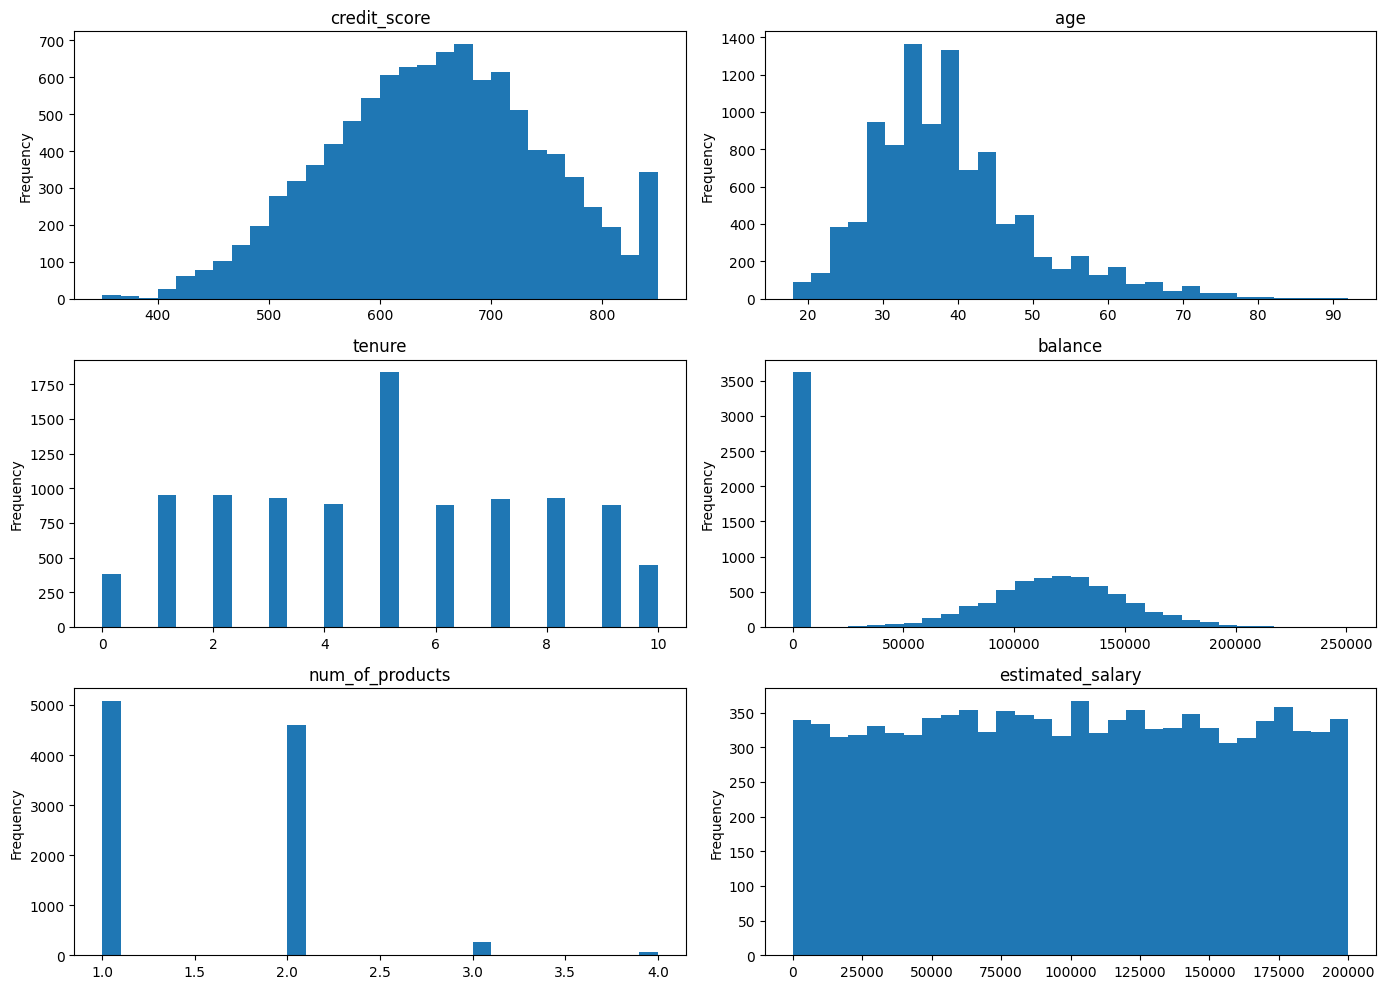

In [23]:
num_graph = len(data_numer)  # obtiene el tamaño de la lista de columnas

num_rows = int(np.ceil(num_graph / 2))  # divide en bloques de dos, obtiene el total de filas del gráfico
num_cols = 2  # siempre serán dos columnas
a = 1  # número para inicializar el conteo de plots

fig = plt.subplots(figsize=(14, 10))  # tamaño de los subplots

for i in data_numer:  # bucle para cada elemento de la lista
    plt.subplot(num_rows, num_cols, a) 
    plt.title(i)
    data_beta_ohe[i].plot(kind='hist', title=i, bins=30)  # grafica histogramas de cada columna del dataset
    a += 1
    
plt.tight_layout()
plt.show()

En orden, de las columnas numéricas, notamos:
* ``credit_score`` tiene un ligero sesgo negativo, y resalta una agrupación de personas que tienen un score alto, hacia la parte extrema superior de la distribución, algo completamente esperable de una entidad financiera. Aunque sería necesario revisar si la proporción de clientes con buen score crediticio es realmente adecuada para el banco. 
* ``age`` muestra que los clientes del banco son en su mayor parte adultos, entre los 30 y 45 años aprox. Hay una proporción de edades que parecen ser menos comunes desde los 60 años en adelante, aunque con cierta relevancia.
* ``tenure`` muestra la modificación realizada cuando tratamos los valores ausentes, una agrupación hacia su valor mediano. Por lo demás, es una variable bastante homogénea. 
* ``balance`` nos muestra que buena parte de los clientes tienen un saldo cero en sus cuentas, siendo este valor el más frecuente de la distribución. Este es una ventana de oportunidad o una muestra de que el banco tiene problemas para retener fondos de sus clientes, aunque de cierta forma es esperable que una buena parte de los clientes no tengan saldos positivos en sus cuentas. El otro pico está cerca a las 100 mil unidades monetarias, lo cual indica que los clientes que sí tienen depósitos en el banco, un 50 % de ellos tienen de saldo 100 mil u.m. (el promedio debería estar cerca).
* ``num_of_products`` es una variable discreta. Esta variable también nos indicaría que la mayor parte de los clientes tienen 1 o 2 productos en el banco. Aunque hay personas que tienen hasta 4 productos. Aquí también hay una oportunidad de mejora o un síntoma de alerta acerca del comportamiento de los usuarios. 
* ``estimated_salary`` parece ser una variable bastante homogénea según los datos del banco. Esto no tiene que ser cierto en la vida real, ya que se espera que existan pocas personas con ingresos extremos. Dado que esta parece ser una estimación, es posible que sea necesaria una revisión de los métodos de obtención de esta variable. En términos prácticos, tener muchos clientes de altos ingresos son otra posible ventana a más oportunidades, aunque no sabemos si estos usuarios son realmente activos o no.

Debido a que muchos de los valores extremos posiblemente estén relacionados con la decisión de salir o no del banco (el target: *exited*), los preservaremos para obtener la mayor información posible. 


## Relación de las columnas numéricas con la variable objetivo

Continuando con el análisis exploratorio, para probar alguna de nuestras hipótesis, analizaremos el comportamiento de estas columnas numéricas por los valores de nuestro target ``exited``. Nuevamente haremos un gráfico múltiple para simplificar el proceso:

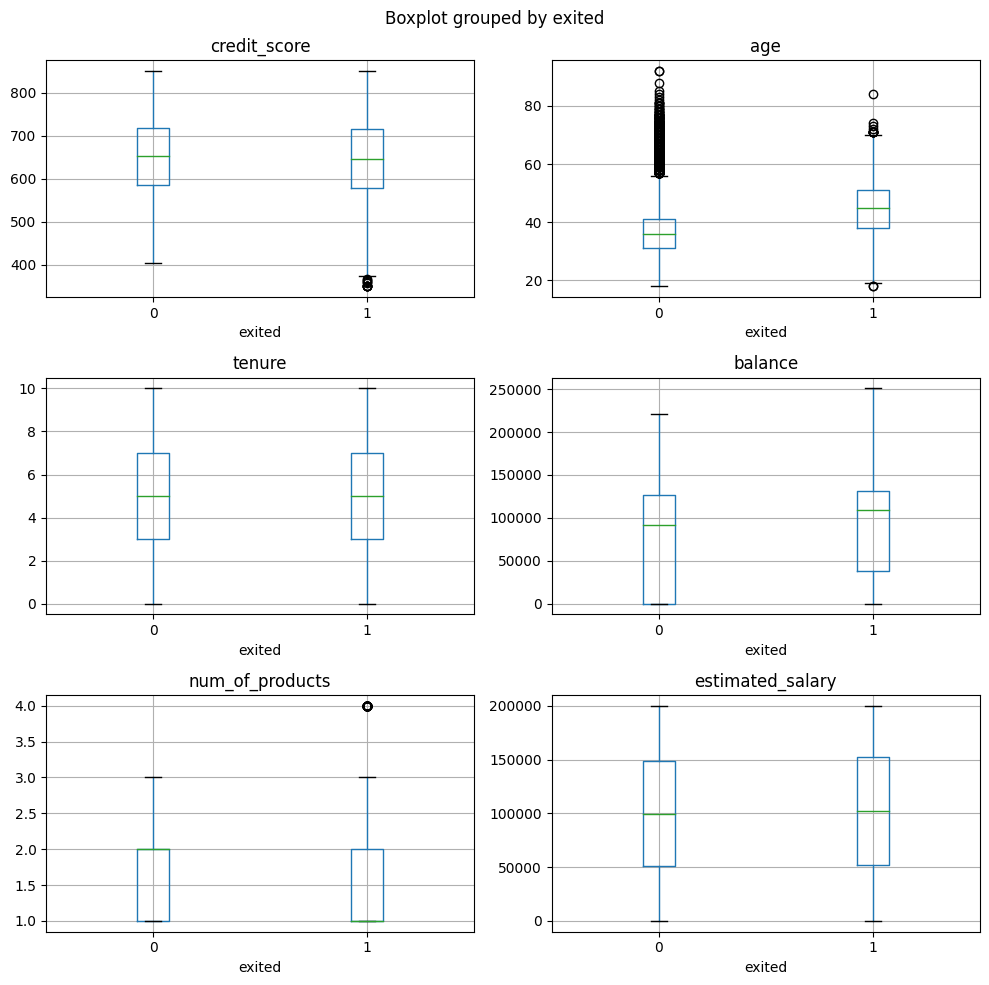

In [24]:
# Crear la figura y los subplots con el tamaño especificado
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Bucle para generar los subplots para cada columna numérica
for i, ax in zip(data_numer, axes.flatten()):
    ax.set_title(i)  # Asignar el título de la columna al subplot
    data_beta_ohe.boxplot(by='exited', column=i, ax=ax) # Graficar el boxplot para la columna i, separando por la variable 'exited'

plt.tight_layout() # Ajustar el diseño de los subplots para que no se superpongan
plt.show()

Nuevamente en orden, observamos lo siguiente si realizamos diagramas de caja de ``exited`` por cada columna numérica del dataset:
* ``credit_score`` no muestra grandes diferencias para los clientes que dejaron el banco. Posiblemente la relación entre estas variables sea bastante débil.
* ``age`` muestra una diferencia más marcada: la mayor parte de personas que dejaron el banco tienen alrededor de 45 años de edad. Parece que mientras más edad tienen los clientes, es alg más probable que dejen el banco. 
* Para ``tenure``, tampoco observamos diferencias significativas (es posible que sea por el proceso de imputación de valores ausentes).
* El gráfico de ``balance`` muestra que los clientes que dejaron el banco tienen (o tenían) un saldo de cuenta ligeramente más alto que los que no. En términos porcentuales no parece ser muy grande la diferencia, pero existe.
* ``num_of_products`` indica que el 50 % de los clientes que dejaron el banco tenían solo 1 producto, mientras que el 50 % de los que clientes actuales tiene 2 productos. Esta diferencia resulta en que esta variable podría ser un buen indicador de un cliente en posibilidad de irse.
* En caso de ``estimated_salary``, no parecen existir diferencias significativas entre los salarios promedios (y medianos) para los clientes que dejaron o no el banco.

## Relación de las columnas restantes con la variable objetivo

Nos falta analizar las columnas restantes y su comportamiento para los clientes que dejaron el banco y los que no. En este caso usaremos Seaborn y también haremos el gráfico con un bucle para hacerlo de forma automatizada:

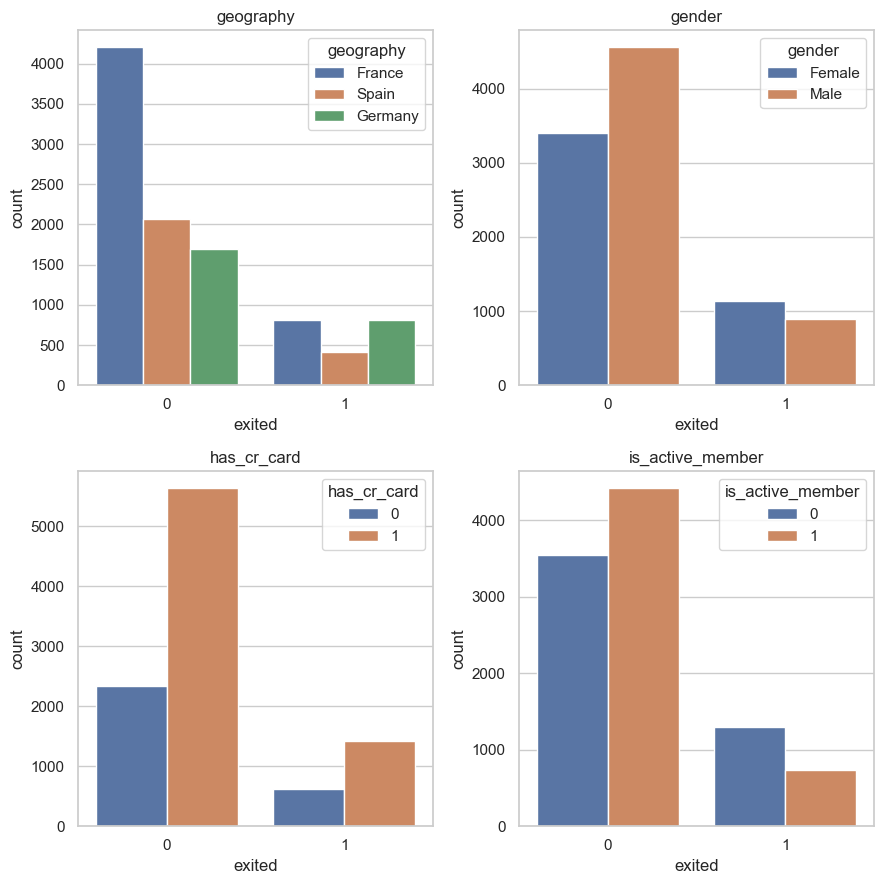

In [25]:
sns.set_theme(style='whitegrid')

data_other = ['geography', 'gender', 'has_cr_card', 'is_active_member'] # columnas restantes del dataset

# Crear la figura y los subplots con el tamaño especificado
fig, axes = plt.subplots(2, num_cols, figsize=(9, 9))

# Bucle para generar los subplots para cada columna restante
for i, ax in zip(data_other, axes.flatten()):
    ax.set_title(i)  # Asignar el título de la columna al subplot
    sns.countplot(data=data_beta, x='exited', hue=i, ax=ax)

plt.tight_layout() # Ajustar el diseño de los subplots para que no se superpongan
plt.show()

De arriba hacia abajo, de izquierda a derecha, tenemos:
* En el caso de ``geography``, resalta que los clientes que dejaron el banco son en su mayor parte de Francia y Alemania, mientras que los que son clientes aún, son mayormente de Francia. Destaca el caso de Alemania, y es una situación a analizar a profundidad: por qué los clientes de ese país tienden a dejar más el banco que los de España, y casi en la misma proporción que Francia.
* Para el caso de ``gender``, resalta el hecho de que las mujeres son por poco las que más dejaron el banco, aunque en términos generales el banco tiene más hombres en sus registros. Otra característica a estudiar y tomar en cuenta.
* El gráfico de ``has_cr_card`` muestra de forma aproximada el mismo comportamiento para los clientes que dejaron el banco y los que no. Quizá no sea una variable tan relevante en este caso.
* La situación cambia para ``is_active_member``. En proporción, casi el doble de los que dejaron el banco no eran miembros activos del banco, contrario a los clientes que no dejan el banco aún. Este puede ser un gran indicador para anticipar si un cliente está en mayores posibilidades de dejar el banco.

## Conclusiones del apartado

En este apartado logramos obtener información interesante para nuestro análisis. Resumiremos lo hallado en los siguientes puntos:
* De las columnas numéricas, destacan las oportunidades de mejora (o alerta) que nos dan ``credit_score``, ``balance`` y ``num_of_products``. 
* De las columnas numéricas, las que mostraron una relación más significativa o comportamiento distinto para los clientes que dejaron el banco son ``credit_score``, ``age``, ``balance`` y ``num_of_products``. 
* De las columnas restantes, todas mostraron un comportamiento diferente para los clientes que dejaron el banco de los que no (``geography``, ``gender``, ``is_active_member``), excepto ``has_cr_card``, la cual no mostró diferencias significativas para ambos tipos de clientes.
* Algunas columnas numéricas parecen mostrar valores atípicos, pero decidimos no tratarlos debido a que es posible que estos capturen parte de la variable objetivo. Es decir, priorizaremos preservar la mayor cantidad de información posible para mejorar la calidad del modelo final.

# Estandarización y segmentación de datos

## Estandarización de datos

Ahora continuaremos con la estandarización de las variables numéricas para seguir las buenas prácticas. Recordemos que tenemos en una lista a nuestras variables numéricas:

In [27]:
data_numer

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'estimated_salary']

Ya que tenemos la lista de nombres, necesitamos llamar y usar el escalador:

In [29]:
scaler = StandardScaler() # guardando el estandarizador

scaler.fit(data_beta_ohe[data_numer])  # entrena al estandarizador

data_beta_ohe[data_numer] = scaler.transform(data_beta_ohe[data_numer])  # actualiza el escalado

data_beta_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,-0.326221,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0,0,1,0


## Segmentación de datos

Recordemos que nuestra variable objetivo es ``exited``. El modelo que probaremos tiene el supuesto de que ``exited`` se relaciona de forma teórica con las demás variables del dataset (features). Es decir, nuestras *features* determinarán si el cliente va a dejar el banco o no. 

Para realizar de forma exitosa el proceso de modelamiento y realizar las pruebas necesarias, dividiremos nuestro dataset en conjuntos de entrenamiento, validación y de prueba. Usaremos la proporción 3:1:1 (60-20-20) y "train_test_split" para este objetivo:

In [31]:
random_state = 200  # guardamos la semilla aleatoria

In [32]:
target = data_beta_ohe['exited'] # variable objetivo
features = data_beta_ohe.drop('exited', axis=1) # características

Primera división: 60 % de entrenamiento - 40 % restante

In [33]:
target_train, target_split, features_train, features_split = train_test_split(target, features, test_size=0.4, random_state=random_state)
# primera división

El 40 % restante de la anterior línea se dividirá en conjuntos de validación y prueba a mitades iguales:

In [34]:
target_valid, target_test, features_valid, features_test = train_test_split(target_split, features_split, test_size=0.5, random_state=random_state)
# segunda división, el restante a mitades iguales 

Para verificar, observaremos el atributo *shape* de cada set:

In [35]:
for i in [target_train, target_valid, target_test, features_train, features_valid, features_test]:
    print()
    print(i.shape) # imprime el atributo shape para cada dataset


(6000,)

(2000,)

(2000,)

(6000, 11)

(2000, 11)

(2000, 11)


## Pequeñas conclusiones del apartado

Logramos estandarizar nuestros datos para mejorar la calidad del modelo. Luego establecimos la relación entre variables objetivo y características, para dividir el dataset original en tres partes: entrenamiento (60 %), validación (20 %) y testing (20 %). Con esto, tenemos preparada la información para empezar con el modelamiento.

# Examinando el equilibrio de clases: modelos sin equilibrar

Comenzaremos por determinar si existe y la proporción del problema de desequilibrio de clases en nuestra variable objetivo. Para esto contaremos los valores de forma porcentual y también gráficamente:

In [40]:
data_beta_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

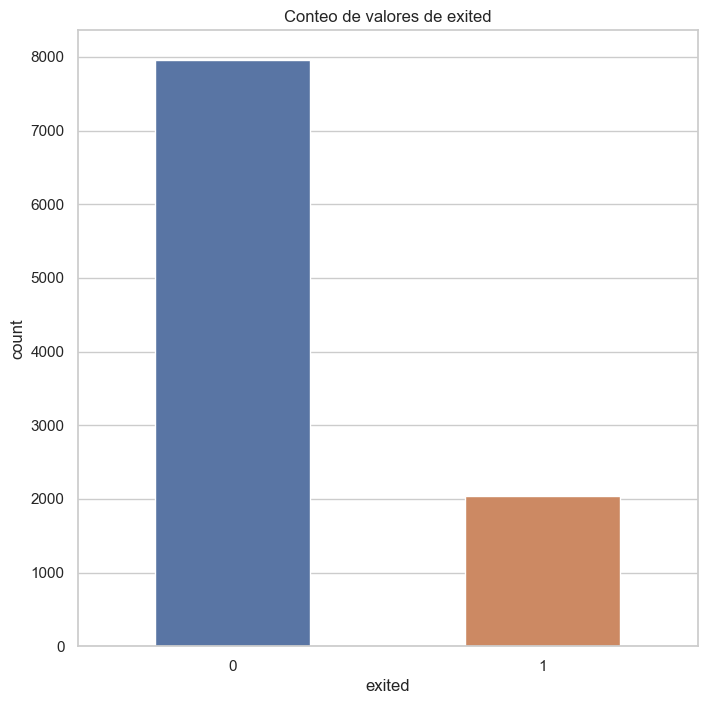

In [45]:
plt.figure(figsize=(8,8))
sns.countplot(data=data_beta_ohe, x='exited', width=0.5)
plt.title('Conteo de valores de exited')
plt.show()

Observamos que las clases de nuestra variable objetivo tienen una proporción de alrededor de 80% - 20%, lo cual puede representar un problema en la calidad de nuestro modelo en términos de capacidad predictiva. Para confirmar esta presunción, en este apartado entrenaremos los modelos sin tener en cuenta este desbalance de clases. Usaremos a los tres modelos más comunes para este objetivo y probaremos diversos parámetros para escoger el óptimo. 

Las métricas a usar serán:
* F1 Score
* AUC-ROC
* Precision
* Recall

La métrica determinante del modelo será el F1 Score. AUC-ROC será para entender la capacidad del modelo, mientras que las dos últimas serán para tener referencia del tipo de error que está cometiendo cada modelo.

## Árbol de decisión desbalanceado

El primer modelo que usaremos es el de árbol de decisión. En este caso, los hiperparámetros que ajustaremos y buscaremos optimizar será el de *max_depth*, optimizando el F1 Score. Para esta optimización, usaremos el objeto *GridSearchCV* de sklearn de la siguiente forma:

In [52]:
tree_model_unbal = DecisionTreeClassifier(random_state=random_state)  # instanciación del modelo

In [78]:
param_grid_tree = {
    'max_depth': range(1, 15)
}

grid_search = GridSearchCV(estimator=tree_model_unbal, param_grid=param_grid_tree, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_tree_unb = grid_search.best_params_
best_param_tree_unb

{'max_depth': 7}

Tal parece que con un *max_depth* de 7 logramos el mejor valor F1 sin tener en cuenta el balance de clases. Obtendremos las otras métricas de este mejor modelo a continuación:

Métricas del árbol de decisión desbalanceado
F1 Score: 0.48105436573311366
Precision: 0.7263681592039801
Recall: 0.35960591133004927
ROC-AUC: 0.8029425307959034
---------------------------------------------------------------


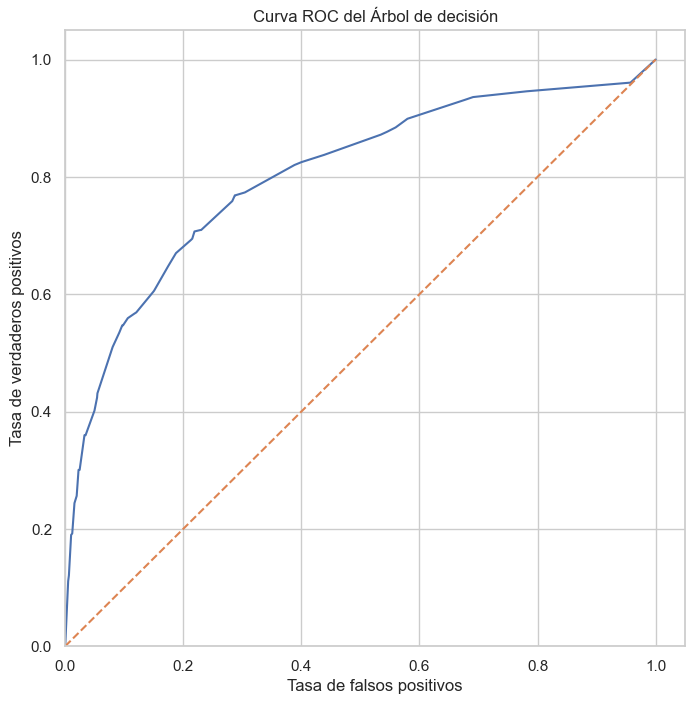

In [80]:
# Modelo de árbol de decisión desbalanceado óptimo 
best_tree_model_unbal = DecisionTreeClassifier(max_depth=best_param_tree_unb['max_depth'], random_state=random_state)
best_tree_model_unbal.fit(features_train, target_train)
predicted_valid = best_tree_model_unbal.predict(features_valid)
print('Métricas del árbol de decisión desbalanceado')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_tree_model_unbal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

# Gráfico de la curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Curva ROC del Árbol de decisión')
plt.show()

Aplicando el parámetro óptimo obtenido de *GridSearchCV* y obteniendo sus demás métricas, encontramos que el valor F1 para el test de validación es de 0.48 y un ROC-AUC de 0.8. Recordemos que necesitamos un F1 Score de al menos 0.59, y estamos algo lejos con este modelo. Es decir, tenemos margen de mejora.

Analizando, observamos que *Recall* es el que está penalizando a nuestro F1. De hecho, este modelo clasifica correctamente como positivo solo un 35 % de las veces que se presenta un ejemplo positivo.

*Precision* resulta ser algo más alto. Nuestro modelo tiene una probabilidad del 72 % de que cuando prediga una muestra positiva, esta sea realmente positiva o correcta.

## Bosque aleatorio desbalanceado

Esta vez continuaremos con el *Random Forest* o Bosque aleatorio. Nuevamente usaremos *GridSearchCV* para optimizar los hiperparámetros del modelo, que en este caso serán *n_estimators* y *max_depth*, buscando el máximo F1 Score.

In [82]:
forest_model_unbal = RandomForestClassifier(random_state=random_state)

In [84]:
param_grid_forest = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 16)
}

grid_search = GridSearchCV(estimator=forest_model_unbal, param_grid=param_grid_forest, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_forest_unb = grid_search.best_params_
best_param_forest_unb

{'max_depth': 12, 'n_estimators': 70}

In [88]:
best_param_forest_unb['n_estimators']

70

GridSearchCV devuelve que los valores de los hiperparámetros a utilizar en esta ocasión serán *max_depth* de 12 y *n_estimators* de 70. Nuevamente entrenaremos al modelo por ahora óptimo para obtener más información con otras métricas.

Métricas del bosque aleatorio desbalanceado
F1 Score: 0.5088566827697263
Precision: 0.7348837209302326
Recall: 0.3891625615763547
ROC-AUC: 0.8452293390856104
---------------------------------------------------------------


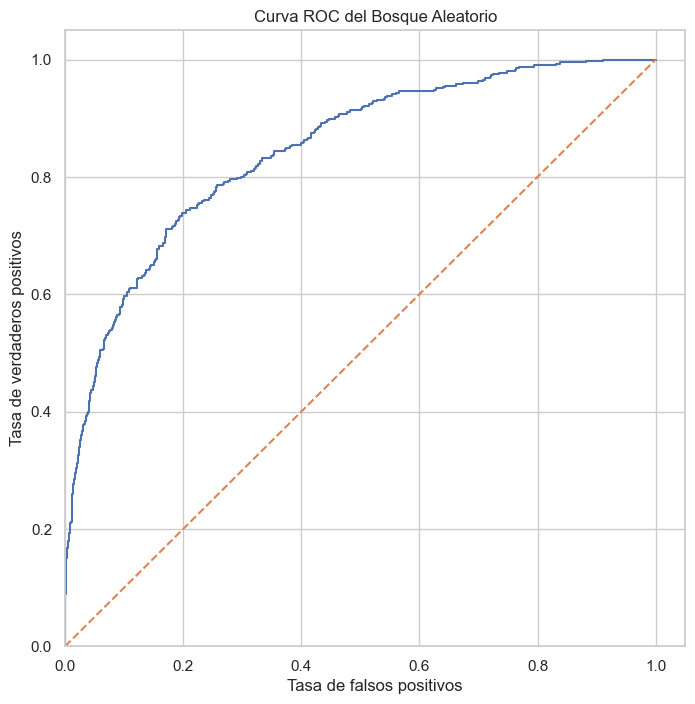

In [89]:
# Modelo de bosque aleatorio desbalanceado óptimo 
best_forest_model_unbal = RandomForestClassifier(
    n_estimators=best_param_forest_unb['n_estimators'], 
    max_depth=best_param_forest_unb['max_depth'], 
    random_state=random_state
)
best_forest_model_unbal.fit(features_train, target_train)
predicted_valid = best_forest_model_unbal.predict(features_valid)
print('Métricas del bosque aleatorio desbalanceado')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_forest_model_unbal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

# Gráfico de la curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Curva ROC del Bosque Aleatorio')
plt.show()

De forma parecida al árbol de decisión, tenemos un F1 score debajo del umbral requerido, de 0.51 aprox. Mientras por el lado del ROC-AUC, este sufre de un ligero incremento hasta ser de 0.84. Este modelo también tiene un gran margen de mejora.

Observamos que la métrica que penaliza al F1 es *Recall*, con un valor de 0.39, lo cual indica que el modelo identifica correctamente a los positivos un 35 % de las veces que se le proporciona una muestra positiva.

Por el lado de *Precision*, este tiene un valor de 0.73, indicando que el modelo acierta en predecir una clase positiva un 73 % de las veces. El incremento respecto al árbol de decisión resulta ser algo ligero en estos casos.

## Regresión logística desbalanceada

La regresión logística es menos flexible en el manejo de sus hiperparámetros por su propia naturaleza, y por eso solo variaremos el hiperparámetro *solver* mediante GridSeachCV. 

In [90]:
logistic_model_unbal = LogisticRegression(random_state=random_state)

In [91]:
param_grid_logistic = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=logistic_model_unbal, param_grid=param_grid_logistic, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_logistic_unb = grid_search.best_params_
best_param_logistic_unb

{'solver': 'liblinear'}

El método 'liblinear' es el que mejor resultado nos da según *GridSearchCV*. Usaremos esta configuración para obtener las métricas restantes.

Métricas de la regresión logística desbalanceada
F1 Score: 0.25650557620817843
Precision: 0.5227272727272727
Recall: 0.16995073891625614
ROC-AUC: 0.7638187538243782
---------------------------------------------------------------


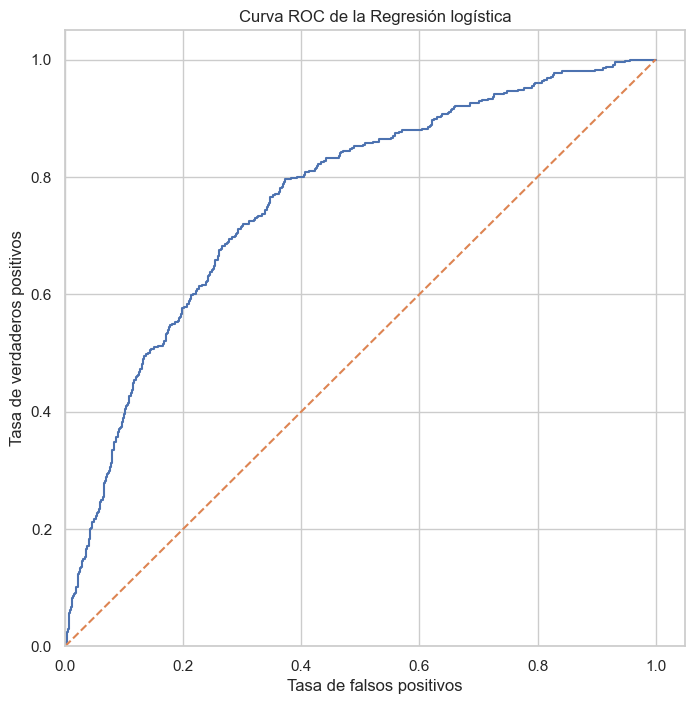

In [93]:
# Modelo de regresión logística desbalanceada óptimo 
best_logistic_model_unbal = LogisticRegression(solver=best_param_logistic_unb['solver'], random_state=random_state)
best_logistic_model_unbal.fit(features_train, target_train)
predicted_valid = best_logistic_model_unbal.predict(features_valid)
print('Métricas de la regresión logística desbalanceada')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_logistic_model_unbal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

# Gráfico de la curva ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Curva ROC de la Regresión logística')
plt.show()

La regresión logística nos da los peores resultados por ahora, con un F1 de 0.26, muy por debajo de lo mínimo solicitado, y un AUC-ROC de 0.76, algo menor que los anteriores modelos.

*Recall* nuevamente penaliza al F1 Score con un valor bastante bajo de 0.17, indicando que este modelo clasifica correctamente como positivo un 17 % de las veces que se le presenta una clase positiva.

*Precision* también se muestra rezagado con un valor de 0.52, indicando que predice correctamente un valor positivo un 52 % de las veces.

## Conclusiones del apartado

Primero, comprobamos la existencia de desbalance de clases en nuestra muestra, con una relación de 80 a 20 aprox., lo cual presumimos que podría tener repercursiones en la capacidad predictiva del modelo.

Los resultados de los entrenamientos están resumidos en el cuadro siguiente:

|   Métrica   |  `DT` | `RF`  |  `LR` |
| ----------- | ----- | ----- | ----- |
|   **F1**    |  0.48 | **0.51** | 0.26 |
| **AUC-ROC** |  0.80 | **0.84** | 0.76 |
|**Precision**|  0.73 | 0.73 | 0.52 |
| **Recall**  |  0.36 | 0.39 | 0.17 |

En todos las métricas, el que resulta con mayor puntaje es el modelo de *Random Forest* o Bosque Aleatorio. Aunque como habíamos mencionado, la diferencia respecto al Árbol de decisión no es muy grande. Debido a que ningún modelo supera el requerimiento mínimo de F1 score, como siguiente paso tendremos en cuenta este desbalance de clases al momento de entrenar los modelos.

# Mejora de los modelos: modelamiento con equilibrio de clases

En esta etapa usaremos los siguientes métodos para intentar mejorar el rendimiento de los modelos que hemos entrenado. Los métodos serán:
* **Ajuste de peso de clases**: esto mediante la configuración del hiperparámetro ``class_weight`` de los modelos.
* **Sobremuestreo**: esto multiplicando de manera aleatoria las clases más escasas (``exited``= 1).
* **Submuestro**: esto restando de manera aleatoria las clases más frecuentes (``exited``= 0).

## Ajuste de peso de clases

Entrenaremos y obtendremos los nuevos hiperparámetros óptimos para cuando se configura el hiperparámetro ``class_weight = 'balanced'``. Esto compensará la proporción de las clases menos frecuentes para tratar de solucionar el problema. Nuevamente llamamos a *GridSearchCV* para el proceso. Comenzaremos por el árbol de decisión:

### Árbol de decisión balanceado

In [97]:
tree_model_bal = DecisionTreeClassifier(random_state=random_state, class_weight='balanced') # instancia el modelo

In [100]:
param_grid_tree = {
    'max_depth': range(1, 15)
}

grid_search = GridSearchCV(estimator=tree_model_bal, param_grid=param_grid_tree, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_tree_bal = grid_search.best_params_
best_param_tree_bal

{'max_depth': 5}

Esta vez, el valor de ``max_depth`` óptimo es 5. Obtendremos las métricas restantes con este hiperparámetro óptimo para analizar el modelo:

In [114]:
# Modelo de árbol de decisión balanceado óptimo 
best_tree_model_bal = DecisionTreeClassifier(
    class_weight='balanced', 
    max_depth=best_param_tree_bal['max_depth'], 
    random_state=random_state
)
best_tree_model_bal.fit(features_train, target_train)
predicted_valid = best_tree_model_bal.predict(features_valid)
print('Métricas del árbol de decisión balanceado')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_tree_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas del árbol de decisión balanceado
F1 Score: 0.542314335060449
Precision: 0.4175531914893617
Recall: 0.7733990147783252
ROC-AUC: 0.8259907844070435
---------------------------------------------------------------


El valor F1 muestra una ligero incremento respecto al modelo sin balancear, aunque sin superar aún el valor mínimo requerido, mientras que el ROC-AUC muestra un comportamiento similar, subiendo ligeramente. 

La razón del incremento de F1 Score se debe al incremento de *Recall*, aumentando drásticamente su valor respecto al modelo sin balancear. Esta vez es *Precision* el que penaliza el valor F1, con una disminución notable. En otros términos podríamso afirmar que este modelo ha mejorado su desempeño de clasificar correctamente los valores de la muestra a cambio de perder capacidad de predecir correctamente.

### Bosque aleatorio balanceado

In [103]:
forest_model_bal = RandomForestClassifier(class_weight='balanced', random_state=random_state)

In [104]:
param_grid_forest = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 16)
}

grid_search = GridSearchCV(estimator=forest_model_bal, param_grid=param_grid_forest, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_forest_bal = grid_search.best_params_
best_param_forest_bal

{'max_depth': 9, 'n_estimators': 90}

Esta vez tenemos ``max_depth`` = 9 y ``n_estimators`` = 90. Con estos valores obtendremos las métricas restantes:

In [115]:
# Modelo de bosque aleatorio balanceado óptimo 
best_forest_model_bal = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=best_param_forest_bal['n_estimators'], 
    max_depth=best_param_forest_bal['max_depth'], 
    random_state=random_state
)
best_forest_model_bal.fit(features_train, target_train)
predicted_valid = best_forest_model_bal.predict(features_valid)
print('Métricas del bosque aleatorio balanceado')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_forest_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')


Métricas del bosque aleatorio balanceado
F1 Score: 0.5944055944055944
Precision: 0.5641592920353983
Recall: 0.6280788177339901
ROC-AUC: 0.8519926942784211
---------------------------------------------------------------


Esta vez el F1 Score ha subido de forma significativa hasta por fin tener el valor requerido. El ROC-AUC incremnta su valor de forma marginal.

Tenemos un comportamiento similar al del modelo anterior, donde *Recall* incrementa su valor y *Precision* decrece, aunque en ambos casos de forma más moderada, logrando que su promedio armónico (F1 Score) sea mayor.

### Regresión logística balanceada

In [107]:
logistic_model_bal = LogisticRegression(class_weight='balanced', random_state=random_state)

In [108]:
param_grid_logistic = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=logistic_model_bal, param_grid=param_grid_logistic, cv=3, scoring='f1')
grid_search.fit(features_train, target_train)

best_param_logistic_bal = grid_search.best_params_
best_param_logistic_bal

{'solver': 'liblinear'}

El hiperparámetro a utilizar será ``solver``= 'liblinear' para obtener las demás métricas:

In [117]:
# Modelo de regresión logística balanceada óptimo 
best_logistic_model_bal = LogisticRegression(
    class_weight='balanced',
    solver=best_param_logistic_bal['solver'], 
    random_state=random_state
)
best_logistic_model_bal.fit(features_train, target_train)
predicted_valid = best_logistic_model_bal.predict(features_valid)
print('Métricas de la regresión logística balanceada')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_logistic_model_bal.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas de la regresión logística balanceada
F1 Score: 0.49572649572649574
Precision: 0.3795811518324607
Recall: 0.7142857142857143
ROC-AUC: 0.7671177630399714
---------------------------------------------------------------


Este modelo también presenta mejoras notables respecto a su análogo sin balancear. El F1 Score casi se duplica (pero no alcanza el umbral requerido), aunque el ROC-AUC mantiene su valor.

Esta mejora del valor F1 se debe a la significativa mejora de *Recall*, multiplicando su valor varias veces. Mientras que *Precision* muestra una caída algo importante. 

En definitiva, en todos los modelos el F1 Score se incrementa a cambio de una reducción de *Precision* y un gran aumento del valor *Recall*

### Síntesis y comparación de métricas

Luego de haber entrenado los modelos con y sin ajuste de peso de clases, resumiremos lo hallado en los siguientes cuadros para facilitar las conclusiones del apartado:

**F1 Score**

|   Modelo   |  Desbalance | Balance  |  Efecto final |
| ----------- | ----- | ----- | ----- |
|``DT``  |  0.48 | **0.54** | Mejora |
| ``RF`` |  0.51 | **0.59** | Mejora |
| ``LR`` | 0.26  | **0.50**  | Mejora |

## Sobremuestreo

Este método requiere de incrementar de forma aleatoria la cantidad de observaciones escasas para compensarlas y tener una proporción más equilibrada de clases. Para lograr esto, crearemos una función de la siguiente manera:

In [118]:
# función de sobremuestreo: upsample

def upsample(features, target, repeat):
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]      # separa las variables
    
    features_upsampled = pd.concat([features_0] + [features_1] * repeat)
    target_upsampled = pd.concat([target_0] + [target_1] * repeat)      # multiplica los valores escasos
    
    # aleatoriza los nuevos datos
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state)
    
    return features_upsampled, target_upsampled

Ahora que creamos la función, podemos utilizarla para emparejar las clases de nuestra variable objetivo. Recordemos que la proporción era de 80 - 20, así que multiplicando por 4 deberíamos tener una distribución más pareja de las clases:

In [121]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

target_upsampled.value_counts(normalize=True)

1    0.50156
0    0.49844
Name: exited, dtype: float64

Ahora que tenemos a nuestro target más equilibrado, entrenaremos y obtendremos las métricas de cada uno de los modelos probados hasta ahora.

### Árbol de decisión con sobremuestreo

Nuevamente usaremos *GridSearchCV* para obtener los mejores valores de los hiperparámetros de los modelos y así obtener las métricas con el set de validación:

In [122]:
tree_model_up = DecisionTreeClassifier(random_state=random_state) # instancia el modelo

In [126]:
param_grid_tree = {
    'max_depth': range(5, 21)
}

grid_search = GridSearchCV(estimator=tree_model_up, param_grid=param_grid_tree, cv=3, scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

best_param_tree_up = grid_search.best_params_
best_param_tree_up

{'max_depth': 19}

El mejor árbol se da con ``max_depth`` = 19. Lo probaremos ahora obteniendo las métricas con el set de validación:

In [137]:
# Modelo de árbol de decisión con sobremuestra óptimo 
best_tree_model_up = DecisionTreeClassifier( 
    max_depth=best_param_tree_up['max_depth'], 
    random_state=random_state
)
best_tree_model_up.fit(features_upsampled, target_upsampled)
predicted_valid = best_tree_model_up.predict(features_valid)
print('Métricas del árbol de decisión con sobremuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_tree_model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas del árbol de decisión con sobremuestreo
F1 Score: 0.46326276463262767
Precision: 0.46851385390428213
Recall: 0.458128078817734
ROC-AUC: 0.6671608742142642
---------------------------------------------------------------


Obtenemos un F1 algo más bajo a pesar del sobremuestreo, con un valor de 0.46, debajo de lo requerido. El ROC-AUC también es más bajo que el modelo sin tratar.

Observamos que el valor F1 más bajo tiene relación con los valores de *Recall* y *Precision*, siendo estos más bajos que los modelos previos y también bastante parejos. Dependiendo del contexto, esto podría ser conveniente o no. Continuaremos con el siguiente modelo.

### Bosque aleatorio con sobremuestreo

In [138]:
forest_model_up = RandomForestClassifier(random_state=random_state)

In [139]:
param_grid_forest = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 16)
}

grid_search = GridSearchCV(estimator=forest_model_up, param_grid=param_grid_forest, cv=3, scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

best_param_forest_up = grid_search.best_params_
best_param_forest_up

{'max_depth': 15, 'n_estimators': 40}

Con estos hiperparámetros obtendremos las demás métricas:

In [156]:
# Modelo de bosque aleatorio con sobremuestro óptimo 
best_forest_model_up = RandomForestClassifier(
    n_estimators=best_param_forest_up['n_estimators'], 
    max_depth=best_param_forest_up['max_depth'], 
    random_state=random_state
)
best_forest_model_up.fit(features_upsampled, target_upsampled)
predicted_valid = best_forest_model_up.predict(features_valid)
print('Métricas del bosque aleatorio con sobremuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_forest_model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas del bosque aleatorio con sobremuestreo
F1 Score: 0.5564516129032258
Precision: 0.6124260355029586
Recall: 0.5098522167487685
ROC-AUC: 0.8322843977724348
---------------------------------------------------------------


De forma parecida, el valor F1 se incrementa, pero no está en el límite mínimo requerido. No hay un incremento del ROC-AUC, de hecho, este cae.

Nuevamente notamos un mayor equilibrio entre los valores de *Recall* y *Precision*, motivo del valor F1.

### Regresión logística con sobremuestreo

In [141]:
logistic_model_up = LogisticRegression(random_state=random_state)

In [142]:
param_grid_logistic = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=logistic_model_up, param_grid=param_grid_logistic, cv=3, scoring='f1')
grid_search.fit(features_upsampled, target_upsampled)

best_param_logistic_up = grid_search.best_params_
best_param_logistic_up

{'solver': 'saga'}

Usaremos esa configuración para calcular las métricas restantes:

In [157]:
# Modelo de regresión logística con sobremuestreo óptimo 
best_logistic_model_up = LogisticRegression(solver=best_param_logistic_up['solver'], random_state=random_state)
best_logistic_model_up.fit(features_upsampled, target_upsampled)
predicted_valid = best_logistic_model_up.predict(features_valid)
print('Métricas de la regresión logística con sobremuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_logistic_model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas de la regresión logística con sobremuestreo
F1 Score: 0.4948805460750854
Precision: 0.3785900783289817
Recall: 0.7142857142857143
ROC-AUC: 0.7671223986501103
---------------------------------------------------------------


Nuevamente observamos un incremento en el valor F1 respecto al modelo sin tratar, aunque esta vez tampoco superamos el umbral mínimo. El ROC-AUC se mantiene prácticamente en su valor, incrementándose muy ligeramente.

La razón detrás del rezago de F1 es principalmente *Precision*, con un valor bastante bajo respecto a *Recall*, el cual sí muestra una mejora significativa respecto al modelo sin balancear.

### Síntesis y comparación de métricas

Sintetizaremos lo encontrado con los modelos entrenados con sobremuestreo en un cuadro comparativo con el valor F1 respecto al primer modelo:

**F1 Score**

|   Modelo   |  Desbalance | Sobremuestreo  |  Efecto final |
| ----------- | -------- | ---------- | -------------- |
| ``DT`` |      0.48 |          0.46 |      Deterioro |
| ``RF`` |      0.51 |      **0.56** |      Mejora |
| ``LR`` |      0.26 |      **0.49**  |      Mejora |

## Submuestreo

Este método eliminará muestras de la clase más frecuente de forma aleatoria, teniendo esto ciertas desventajas respecto a su uso. Sin embargo, decidimos usarlo por si nos proporciona un mejor desempeño que el sobremuestreo. De forma análoga al sobremuestreo, crearemos una función que nos ayude en el proceso de submuestreo:

In [148]:
# función de submuestreo: downsample

def downsample(features, target, fraction):
    features_0 = features[target == 0]
    features_1 = features[target == 1]
    target_0 = target[target == 0]
    target_1 = target[target == 1]      # separa las variables
    
    features_downsampled = pd.concat([features_0.sample(frac=fraction, random_state=random_state)] + [features_1])
    target_downsampled = pd.concat([target_0.sample(frac=fraction, random_state=random_state)] + [target_1])      # extrae los valores escasos
    
    # aleatoriza los nuevos datos
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=random_state)
    
    return features_downsampled, target_downsampled

Recordando que la proporción era de 80 - 20, una fracción de 1/4 (0.25) debería ser suficiente para equilibrar las clases:

In [149]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

target_downsampled.value_counts(normalize=True)

1    0.501664
0    0.498336
Name: exited, dtype: float64

Ahora podemos probar los modelos con estas nuevas muestras.

### Árbol de decisión con submuestreo

In [150]:
tree_model_down = DecisionTreeClassifier(random_state=random_state) # instancia el modelo

In [152]:
param_grid_tree = {
    'max_depth': range(1, 16)
}

grid_search = GridSearchCV(estimator=tree_model_down, param_grid=param_grid_tree, cv=3, scoring='f1')
grid_search.fit(features_downsampled, target_downsampled)

best_param_tree_down = grid_search.best_params_
best_param_tree_down

{'max_depth': 6}

Con este hiperparámetro, obtendremos las métricas faltantes:

In [158]:
# Modelo de árbol de decisión con submuestra óptimo 
best_tree_model_down = DecisionTreeClassifier( 
    max_depth=best_param_tree_down['max_depth'], 
    random_state=random_state
)
best_tree_model_down.fit(features_downsampled, target_downsampled)
predicted_valid = best_tree_model_down.predict(features_valid)
print('Métricas del árbol de decisión con submuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_tree_model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas del árbol de decisión con submuestreo
F1 Score: 0.5432558139534884
Precision: 0.43647234678624813
Recall: 0.7192118226600985
ROC-AUC: 0.8174172234549509
---------------------------------------------------------------


El valor de F1 no es lo suficientemente alto aunque muestre mejora comparado al modelo sin tratar. Incluso el ROC-AUC muestra un retroceso.

Tanto *Recall* como *Precision* mostraron un retroceso en sus valores, lo cual no ayuda a este método de tratamiento.

### Bosque aleatorio con submuestreo

In [154]:
forest_model_down = RandomForestClassifier(random_state=random_state)

In [155]:
param_grid_forest = {
    'n_estimators': range(10, 101, 10),
    'max_depth': range(5, 16)
}

grid_search = GridSearchCV(estimator=forest_model_down, param_grid=param_grid_forest, cv=3, scoring='f1')
grid_search.fit(features_downsampled, target_downsampled)

best_param_forest_down = grid_search.best_params_
best_param_forest_down

{'max_depth': 10, 'n_estimators': 60}

Ahora obtendremos las demás métricas:

In [159]:
# Modelo de bosque aleatorio con submuestro óptimo 
best_forest_model_down = RandomForestClassifier(
    n_estimators=best_param_forest_down['n_estimators'], 
    max_depth=best_param_forest_down['max_depth'], 
    random_state=random_state
)
best_forest_model_down.fit(features_downsampled, target_downsampled)
predicted_valid = best_forest_model_down.predict(features_valid)
print('Métricas del bosque aleatorio con submuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_forest_model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas del bosque aleatorio con submuestreo
F1 Score: 0.5678776290630975
Precision: 0.4640625
Recall: 0.7315270935960592
ROC-AUC: 0.8400420913400621
---------------------------------------------------------------


Aunque tenemos una mejora que casi se aproxima al valor mínimo, F1 Score aún está algo lejos. AUC-ROC no muestra prácticamente cambios en este caso.

Tanto *Recall* como *Precision* sufren cambios opuestos, esta vez siendo el que penaliza *Precision* y no *Recall* como en el modelo sin equilibrar.

### Regresión logística con submuestreo

In [161]:
logistic_model_down = LogisticRegression(random_state=random_state)

In [162]:
param_grid_logistic = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=logistic_model_down, param_grid=param_grid_logistic, cv=3, scoring='f1')
grid_search.fit(features_downsampled, target_downsampled)

best_param_logistic_down = grid_search.best_params_
best_param_logistic_down

{'solver': 'liblinear'}

Nuevamente entrenaremos y obtendremos los parámetros faltantes:

In [163]:
# Modelo de regresión logística con submuestreo óptimo 
best_logistic_model_down = LogisticRegression(solver=best_param_logistic_down['solver'], random_state=random_state)
best_logistic_model_down.fit(features_downsampled, target_downsampled)
predicted_valid = best_logistic_model_down.predict(features_valid)
print('Métricas de la regresión logística con submuestreo')

# F1 Score
print('F1 Score:', f1_score(target_valid, predicted_valid))

# Precision
print('Precision:', precision_score(target_valid, predicted_valid))

# Recall
print('Recall:', recall_score(target_valid, predicted_valid))

# AUC-ROC
probabilities_valid = best_logistic_model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('ROC-AUC:', roc_auc_score(target_valid, probabilities_one_valid))
print('---------------------------------------------------------------')

Métricas de la regresión logística con submuestreo
F1 Score: 0.4945515507124896
Precision: 0.3748411689961881
Recall: 0.7266009852216748
ROC-AUC: 0.7634927159112682
---------------------------------------------------------------


Este modelo, aunque mejora su rendimiento, tampoco es suficiente para alcanzar el mínimo solicitado. El ROC-AUC se mantiene y tenemos cambios en los valores de *Recall* y *Precision* de formas opuestas. 

Por ahora, hemos agotado las técnicas de mejora del problema de desbalance.

### Síntesis y comparación de métricas

Sintetizaremos lo encontrado con el proceso de submuestreo en un cuadro comparativo de valores F1:

**F1 Score**

|   Modelo   |  Desbalance | Submuestreo  |  Efecto final |
| ----------- | -------- | ---------- | -------------- |
| ``DT`` |      0.48 |      **0.54** |      Mejora |
| ``RF`` |      0.51 |      **0.57** |      Mejora |
| ``LR`` |      0.26 |      **0.49**  |      Mejora |

## Comparación final de métodos y modelos

Hemos construido y entrenado modelos para cada uno de los tratamientos del desbalance de clases, y resumiremos los hallazgos en un cuadro de resumen de valores F1, la métrica determinante:

**F1 Score**

|   Modelo   |  Desbalance | Balance | Sobremuestreo  |  Submuestreo |
| ---------- | ---------- | ------- | ---------- | -------------- |
| ``DT``    |      0.48    | 0.54      |  0.46   |  0.54     |
| ``RF``    |      0.51    | **0.59**  |  0.56   |  0.57     |
| ``LR``    |      0.26    | 0.50      |  0.49   |  0.49     |

**Conclusiones finales del apartado**

Luego de un extenso trabajo por tratar el problema de desbalance de nuestra variable objetivo, probando tres metodologías para cada modelo (ajuste de clase, sobremuestreo y submuestreo) y escogiendo sus hiperparámetros optimizados (mediante *GridSearchCV*), el mejor modelo que logramos entrenar resultó el de **Bosque aleatorio con el ajuste de clase** hacia balanceado, dándonos un valor F1 de 0.59, el valor exacto requerido como mínimo para aprobar el desempeño del modelo. 

# Prueba final del modelo

Una vez escogido el modelo, como paso final probaremos el rendimiento del modelo con el test de prueba para medir su rendimiento frente a datos nuevos. Recordemos que nuestro modelo final es de Bosque aleatorio y sus hiperparámetros óptimos están guardados en la variable ``best_param_forest_bal``.

In [164]:
best_model = RandomForestClassifier(
    class_weight='balanced',
    max_depth=best_param_forest_bal['max_depth'],
    n_estimators=best_param_forest_bal['n_estimators'],
    random_state=random_state
)
best_model.fit(features_train, target_train)
predicted_test = best_model.predict(features_test)
print('Métricas del bosque aleatorio óptimo')

# F1 Score
print('F1 Score:', f1_score(target_test, predicted_test))

# Precision
print('Precision:', precision_score(target_test, predicted_test))

# Recall
print('Recall:', recall_score(target_test, predicted_test))

# AUC-ROC
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))


Métricas del bosque aleatorio óptimo
F1 Score: 0.6343115124153499
Precision: 0.6095444685466378
Recall: 0.6611764705882353
ROC-AUC: 0.8648112044817928


Nuestro modelo final tiene un puntaje F1 Score que satisface el umbral mínimo, con un valor de 0.63 y un ROC-AUC de 0.86, el cual también es bastante alto. 

Por otro lado, observamos que las métricas de *Recall* y *Precision* son bastante parejas, aunque este modelo en especial es mejor reconociendo los verdaderos valores positivos de la muestra (reduciendo los falsos negativos) y un poco menos mejor prediciendo correctamente clases positivas, aunque eso no implica que *Precision* sea realmente bajo.

En conclusión, nuestro modelo ha superado las pruebas.

# Extra: prueba de cordura

Como complemento y extra a las pruebas realizadas, mostraremos el gráfico de la curva ROC para observar el desempeño del modelo frente a un modelo aleatorio, y a su vez compararemos el valor F1 de una predicción aleatoria como prueba de cordura para relativizar la capacidad del modelo.

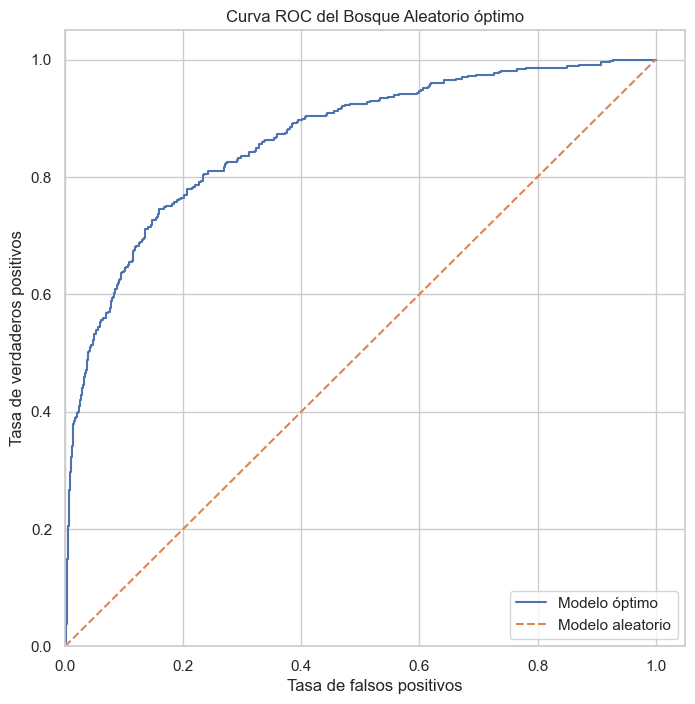


ROC-AUC: 0.8648112044817928


In [171]:
# Gráfico de la curva ROC
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='Modelo óptimo')
plt.plot([0, 1], [0, 1], linestyle='--', label='Modelo aleatorio')
plt.legend(loc = 'lower right')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('Curva ROC del Bosque Aleatorio óptimo')
plt.show()
print()
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

Recordemos que el valor de ROC-AUC es bastante elevado y razonable en nuestro modelo y este parece comportarse de manera corecta frente al modelo aleatorio. Ahora obtendremos el F1 Score de ambos modelos y relativizar el desempeño de nuestro modelo.

In [172]:
np.random.seed(random_state) # semilla aleatoria

In [173]:
sanity_check_pred = np.random.choice([0, 1], size=len(target_test))  # array de ceros y unos con longitud del conjunto de prueba

In [174]:
print(f"F1 score del modelo de Bosque aleatorio óptimo: {f1_score(target_test, predicted_test)}")
print(f"F1 score del modelo aleatorio: {f1_score(target_test, sanity_check_pred)}")

F1 score del modelo de Bosque aleatorio óptimo: 0.6343115124153499
F1 score del modelo aleatorio: 0.3048694424841214


Bajo esta métrica, es evidente la superioridad del modelo final escogido y utilizado. En conclusión, nuestro modelo de bosque aleatorio es superior que otros modelos e incluso que la aleatoriedad.

# Conclusiones

**Preprocesamiento de datos**

* En la primera exploración detectamos problemas referidos a formatos incorrectos de columnas, variables prescindibles no relacionadas a nuestra variable objetivo, y (el más importante) valores ausentes en ``tenure``.
* Se corrigieron los dos problemas iniciales de forma rápida. Para el caso de los valores ausentes, decidimos utilizar una regresión lineal para tratarlos, discretizando sus valores y observando que la distribución de nuestra variable ``tenure`` había variado a causa de la imputación. Este fenómeno ocurre de igual forma utilizando otros métodos como agrupación o imputación directa por mediana.
* En el proceso, convertimos a dummies a las variables categóricas del modelo, utilizando la metodología One-Hot.

**Análisis exploratorio, estandarización y segmentación de datos**

* En el análisis exploratorio encontramos que tenemos variables potencialmente útiles para predecir a nuestra variable objetivo, tanto numéricas como categóricas, así como otras variables que no parecían cambiar significativamente para los valores de la variable objetivo.
* Encontramos valores atípicos, pero dado el posible desbalance de clases y con el objetivo de preservar la mayor información posible, decidimos no tratarlos.
* Estandarizamos las columnas numéricas y dividimos el dataset en tres conjuntos siguiendo la proporción 3:1:1, obteniendo conjuntos de entrenamiento, validación y testing.

**Modelamiento sin y con equilibrio de clases**

* Para optimizar los hiperparámetros de los diferentes modelos, utilizamos *GridSearchCV* por su facilidad y practicidad de uso.
* Primero empezamos el modelamiento sin tener en cuenta el desequilibrio de clases, entrenando modelos de árbol de decisión, bosque aleatorio y regresión logística. En este caso, no logramos obtener el puntaje mínimo solicitado en ningún modelo.
* Luego comprobamos la existencia del desbalance de clases, por lo cual decidimos utilizar tres metodologías para tratar este problema y entrenar nuevamente los tres modelos. El que nos dejó el mejor resultado fue el bosque aleatorio con el ajuste de su hiperparámetro ``class_weight``, alcanzando un F1 Score suficiente para pasar esta etapa.
* Finalmente, con el modelo final, realizamos una última prueba, esta vez utilizando el dataset de testing, el cual nos dio un buen puntaje F1. Para comparar, graficamos su curva ROC e hicimos una prueba de cordura, de la cual el modelo resultó ser el mejor de todos, siendo este el recomendado para pronosticar y anticipar la deserción de clientes de banco.

**Recomendaciones**

Recordemos limitaciones importantes del proyecto y daremos alguna recomendaciones al respecto:
* No se tuvo contacto con el área respectiva acerca de la naturaleza y origen de los valores ausentes de ``tenure``. Tampoco parece que el método utilizado para tratarlos sea el adecuado y esté introduciendo sesgos en las demás etapas del proceso. Se recomienda utilizar técnicas más avanzadas para tratar este problema o determinar la causa de este problema.
* En este proyecto, utilizamos como métrica determinante a F1 Score. El uso de esta métrica debe ser analizada con cautela dado que resulta de un promedio (armónico) entre *Recall* y *Precision*. Es posible que, dependiendo de las políticas y modelo de negocio aplicado, se pueda priorizar una de estas métricas antes que el promedio en sí.
* Utilizamos solo tres modelos "clásicos" de clasificación: *Decision Tree*, *Random Forest* y *Logistic Regression*. Es posible que obtengamos rendimientos distintos con otros modelos de clasificación, siendo recomendable probarlos.
* Teniendo en cuenta todo esto, el modelo recomendado por el autor es el de *Random Forest* con ajuste de clases. El despliegue y uso del modelo será encargado al área correspondiente y se espera un correcto rendimiento incluso ante nueva información.